In [98]:
import re
import string
import string
from pathlib import Path
import math
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.impute import KNNImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
"""
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score, train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
"""



data = pd.read_csv('../RHoMIS_ADS_Project_2021/Data/RHoMIS_Indicators.csv',encoding='latin1')
# data  = pd.read_pickle('./preprocessed_data.pkl')

# Data inspection ---------------------------------------------------------------------------
def inspect_data(data):
	print(data.head())
	print(data.count())
	print(data.shape)
	print(data.info())
	for column in data:
	    print(data[column].describe())

#inspect_data(data)

# Data Wrangling --------------------------------------------------------------------------------


# replace negative values for features that are bounded to be positive only  as distance metrics like Land cultivated measured in hectares or Income and PPP earned 

def replace_negative(data,columns):
    for col in columns:
        data.loc[data[col] < 0] = 0
    


def drop_columns(data):
	negative_col = ['LandCultivated', 'LandOwned', 'currency_conversion_factor','total_income_USD_PPP_pHH_Yr','offfarm_income_USD_PPP_pHH_Yr','value_livestock_prod_consumed_USD_PPP_pHH_Yr','NrofMonthsWildFoodCons']

	categorical_col = ['Country','HouseholdType','Head_EducationLevel']
	# Head_EducationLevel specification about  possible values was not given so we omit this for now 


	replace_negative(data, negative_col)

	data_model = data.copy()
	data_model = data.drop(['ID_PROJ','ID_COUNTRY','SURVEY_ID','Region','ID_HH','Head_EducationLevel','RHoMIS_ID'],axis=1)
# 	data_model.drop(['Head_EducationLevel'],axis=1)
# 	data_model.set_index('RHoMIS_ID')
	return data_model



"""
# Print objects
for col in data:
    if data[col].dtype == object:
        print(col)
"""


def replace_missing_with_nan(data_model):
	# replace  HFIAS status with 0 with missing value 
	data_model.loc[data_model['HFIAS_status'] == 0] = np.NaN


# 	replace WorstFoodSecMonth and BestFoodSecMonth with No_answer or none with  missing value 
	data_model.loc[data_model['WorstFoodSecMonth'] == 'No_answer'] = np.NaN
	data_model.loc[data_model['WorstFoodSecMonth'] == 'None'] = np.NaN
	data_model.loc[data_model['WorstFoodSecMonth'] == 'no_answer'] = np.NaN
	data_model.loc[data_model['BestFoodSecMonth'] == 'No_answer'] = np.NaN
	data_model.loc[data_model['BestFoodSecMonth'] == 'no_answer'] = np.NaN
	data_model.loc[data_model['BestFoodSecMonth'] == 'None'] = np.NaN

	#replace HouseHold type with no answer to missing value 
	data_model.loc[data_model['HouseholdType'] == 'no_answer'] = np.NaN
	data_model.loc[data_model['HouseholdType'] == '0'] = np.NaN

	return data_model



# Dictionary for months in different languange to english


def process_months(var, translations):
    if var in translations:
            return  translations.get(var)
    else: return var    
                


def translate_words(data_model):
	months_to_eng = {'ukuboza': 'dec', 'gashyantare' : 'feb', 'kamena' : 'jun', 'mutarama': 'jan', 'nyakanga' : 'jul' , 'nzeri' : 'sep', 'ukwakira' : 'oct',
                 'gicurasi' : 'may' , 'werurwe' : 'mar', 'kanama' : 'aug', 'ugushyingo' : 'nov' , 'mata' : 'apr'}

	translate = lambda x : process_months(x, months_to_eng)
	data_model['BestFoodSecMonth'] = data_model.BestFoodSecMonth.apply(translate)
	data_model['WorstFoodSecMonth'] = data_model.WorstFoodSecMonth.apply(translate)
	return data_model




def hfias_status_vis(data_model):
	HFIAS_status_count = data_model['HFIAS_status'].value_counts()
	sns.set(style="darkgrid")
	sns.barplot(x = HFIAS_status_count.index, y = HFIAS_status_count.values, alpha=0.9)
	plt.title('Frequency Distribution of HFIAS_status')
	plt.ylabel('Number of Occurrences', fontsize=12)
	plt.xlabel('HFIAS_status', fontsize=12)
	plt.show()


# """
# encode ordinal data 
process_status = {'SeverelyFI': 0,'ModeratelyFI': 1,'MildlyFI': 2,'FoodSecure': 3, 'NaN': 'NaN' }           
# data_model['HFIAS_status'] = data_model.HFIAS_status.apply(process_status)
# data_model['HFIAS_status'].value_counts()
# print
# """

#print(data_model['Country'].value_counts())

data_model = drop_columns(data)
data_model = replace_missing_with_nan(data_model)
data_model['HFIAS_status'].map({'SeverelyFI': 0,'ModeratelyFI': 1,'MildlyFI': 2,'FoodSecure': 3, 'NaN': 'NaN' }  )
# print(data_model['HFIAS_status'])
data_model = translate_words(data_model)
# using one got encoding to encode categorical  data , country and  household type 
enc_data = pd.get_dummies(data_model, prefix=['Nat','Type'], columns=['Country','HouseholdType'])
# enc = OrdinalEncoder();
# enc.fit_transform(enc_data)

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(data_model)
# enc.transform(data_model)
# pickle the data to be used 
enc_data.to_pickle('preprocessed_data.pkl')
#print(enc_data)


# Visualizations
#hfias_status_vis(data_model)

# Imputation ---------------------------------------------------------------------------------

# Graph displaying amount of missing data for each featurei

def missing_data_vis():
	missing_data = pd.DataFrame(data[data.columns[data.isnull().any()]].isnull().sum()/len(data)*100)

	names = []
	for i in range(len(missing_data)):
		names.append(missing_data.iloc[i].name)
	values = []
	for i in range(len(missing_data)):
		values.append(missing_data.iloc[i][0])

	data_1 = {'Features': names,'Missing Data Percentage': values}

	# Dictionary loaded into a DataFrame       
	df = pd.DataFrame(data=data_1)
	df.plot.bar(x="Features", y="Missing Data Percentage", title="Features with Missing Data",figsize=(10,6))
	plt.show(block=True)


#missing_data_vis()




# K means imputation

def knn_imputer(df, column_name):
	imputer = KNNImputer()
	df[column_name] = imputer.fit_transform(df[column_name].to_numpy().reshape(-1,1))
	return df

# Takes a while to run, there are 94 features
def knn_imputer_all_columns(df):
	for col in df.columns:
		print(df[col].dtype)
		if df[col].dtype != object:
			imputer = KNNImputer()
			df[col] = imputer.fit_transform(df[col].to_numpy().reshape(-1,1))
	return df


# Example for running knn_imputer
# col_name = 'GPS_ALT'
# df = knn_imputer(enc_data, col_name)
# print(df['GPS_ALT'])



# df = knn_imputer_all_columns(enc_data)

"""
# Check if there is any NaN in column
for col in df.columns:
	for item in df[col]:
		if math.isnan(item) == True:
			print(item)

"""

# print(data_model)

'\n# Check if there is any NaN in column\nfor col in df.columns:\n\tfor item in df[col]:\n\t\tif math.isnan(item) == True:\n\t\t\tprint(item)\n\n'

In [99]:
# print(df)
# imp_mean = IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0), random_state=0)
# imp_mean.fit(enc_data)
# imp_mean.transform(enc_data)

In [100]:
def month_swapper(month):
    month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12, np.NaN: np.NaN}
    return month_mapping[month]

def cyclical_encoder(data, column):    
    months_in_year = 12
    data[column] = data[column].apply(month_swapper)
#     data_model['HFIAS_status'] = data_model.HFIAS_status.apply(month_swapper)
    sin_name = 'sin' + column
    cos_name = 'cos' + column
#     print(enc_data['WorstFoodSecMonth'])
    data[sin_name] = np.sin(2*np.pi*data[column]/months_in_year)
    data[cos_name] = np.cos(2*np.pi*data[column]/months_in_year)
    data.drop(column, axis=1, inplace=True)
    data.head()
    
 
    

In [101]:
# print(data_model['HFIAS_status'])
print(enc_data['WorstFoodSecMonth'])
cyclical_encoder(enc_data, 'BestFoodSecMonth')
cyclical_encoder(enc_data, 'WorstFoodSecMonth')

0        jul
1        aug
2        sep
3        sep
4        jun
        ... 
35723    feb
35724    feb
35725    feb
35726    feb
35727    jan
Name: WorstFoodSecMonth, Length: 35728, dtype: object


In [104]:
enc_data['sinBestFoodSecMonth']
enc_data['cosWorstFoodSecMonth']

0       -8.660254e-01
1       -5.000000e-01
2       -1.836970e-16
3       -1.836970e-16
4       -1.000000e+00
             ...     
35723    5.000000e-01
35724    5.000000e-01
35725    5.000000e-01
35726    5.000000e-01
35727    8.660254e-01
Name: cosWorstFoodSecMonth, Length: 35728, dtype: float64

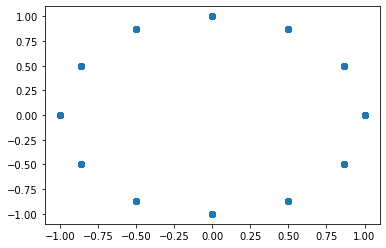

In [107]:
plt.scatter(enc_data['sinBestFoodSecMonth'], enc_data['cosBestFoodSecMonth']
)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  """


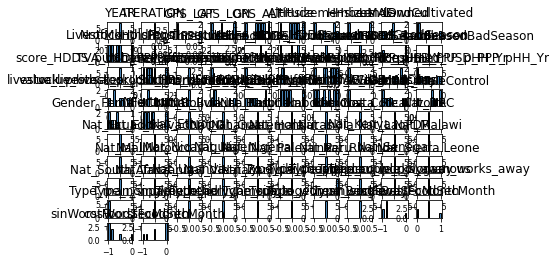

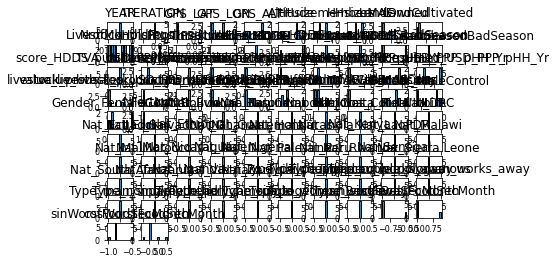

In [111]:
enc_data[:7].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False) 
plt.tight_layout()
# enc_data[8:16].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
#            xlabelsize=8, ylabelsize=8, grid=False)
# plt.tight_layout()



